# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
%matplotlib inline
from pandas.tseries.offsets import MonthEnd
from matplotlib.pylab import rcParams
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = (15, 6)
import pmdarima as pm
print('done')

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


done


# Variables to Set
- Set the data csv name

In [28]:
data = 'forecasting_dataset.csv'
target_column = 'GDP ($ Billions)'
pred_date = '2021-04-17'

# Load/Transform Data

In [29]:
df = pd.read_csv(data)
df.columns = df.columns.str.replace('Date_Time', 'Date')
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.drop('Date',axis=1)
df

,GDP ($ Billions),Federal Interest rate,Unemployment Rate,Temperature (US Average),Consumer Price Index,S&P House price index
Date,,,,,,
2010-01-01,14611.110,0.11,9.8,30.67,216.687,145.00
2010-02-01,14653.075,0.13,9.8,31.80,216.741,143.06
2010-03-01,14779.004,0.16,9.9,43.57,217.631,143.60
2010-04-01,14842.404,0.20,9.9,53.24,218.009,145.39
2010-05-01,14875.794,0.20,9.6,59.88,218.178,147.02
...,...,...,...,...,...,...
2015-08-01,18111.953,0.14,5.1,72.95,238.316,175.12
2015-09-01,18264.133,0.14,5.1,68.54,237.945,175.24
2015-10-01,18182.577,0.12,5.0,57.25,237.838,175.26


# Profile Data

In [10]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Split into Training and Validation Data

In [30]:
train = df[:int(0.80*(len(df)))]
valid = df[int(0.80*(len(df))):]

#plotting the data
ax = train[target_column].plot()
valid[target_column].plot(ax=ax)

KeyError: 'GDP ($ Billions'

# Stationarity
- Stationarity means that the statistical properties of the process do not change over time
- Random variables of the stochastic process remains the same as we shift it along the time index axis. (Mean and Variance)
- Stationary processes are easier to analyze

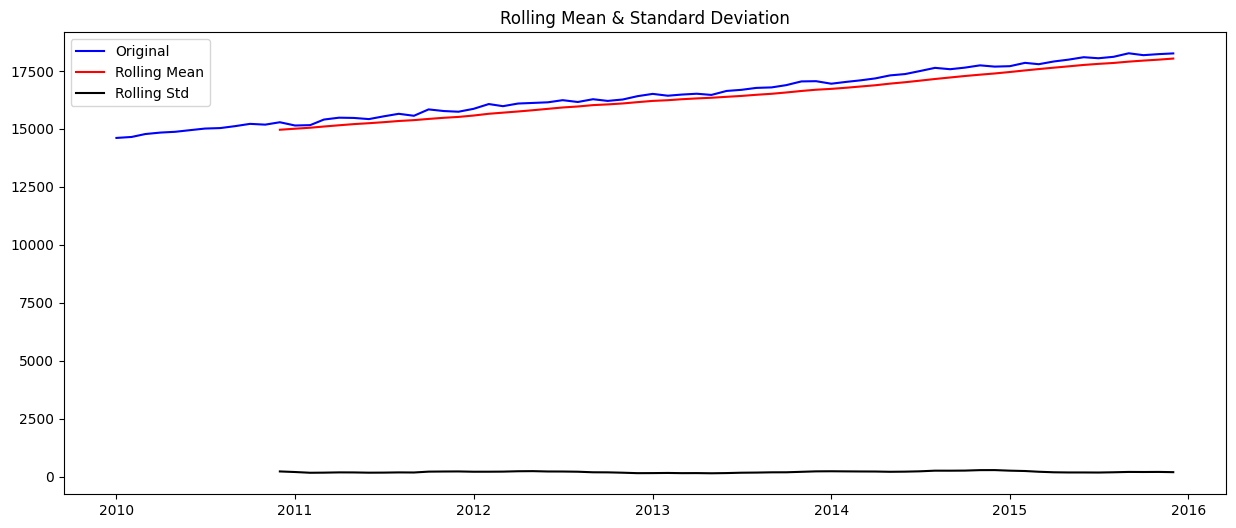

In [17]:
from statsmodels.tsa.stattools import adfuller as adf
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(df[target_column])

#### Analysis of Stationarity
- Even though there is an increasing trend for GDP, the rolling mean and standard deviations do not have large variances from year to year.

# Trends and Seasonality
 - Plot of Original Data
 - Plot of Smoothed Moving Average of Original Data
 - Plot of Seasonality
     - Seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly
 - Plot of Residuals on a Simple Regression Fit
     - What is left over after fitting a model.

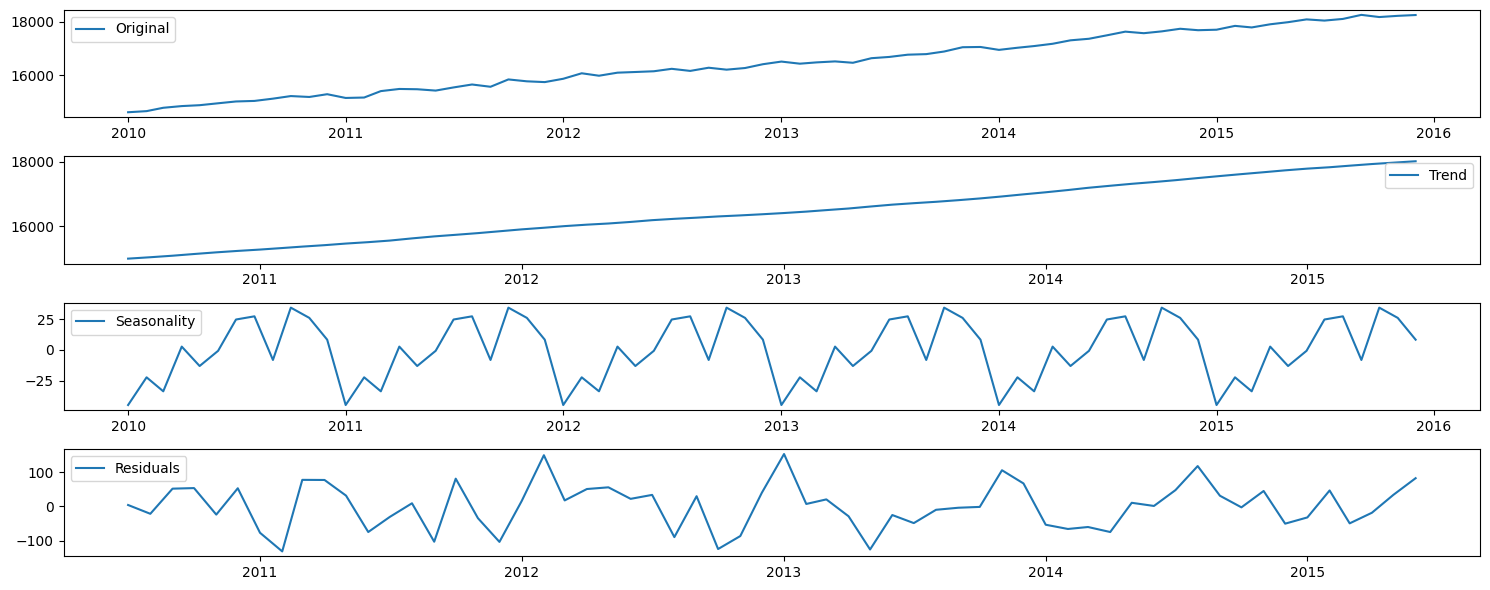

In [18]:
#estimating trend and seasonlity
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df[target_column])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df[target_column], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ARIMA Modeling without Regressors (Only the Target)
- Autoregressive (AR) integrated (I) moving average (MA) models
- We are not going to go into a lot of detail on the parts of ARIMA, Differencing and Lags (This could be multiple college semester courses)
- Instead, what we will do is use Auto-Arima package to find the best model.

In [19]:
best_noregressors = pm.auto_arima(train.iloc[:,0], 
                   trace=True, error_action='ignore', suppress_warnings=True,
                   seasonal=True,
                   m=12, #12 Months
                   stepwise=False,
                   D=None, 
                   max_D=10,
                   start_p=0, start_q=0, 
                   start_P=0, start_Q=0,
                   max_p=5, max_q=5, max_P=5, max_Q=5,
                   information_criterion='aic', #‘aic’, ‘bic’, ‘hqic’, ‘oob’
                   n_jobs = -1,
                  )

print(best_noregressors)
print('Order :',best_noregressors.order)
print('Seasonal Order :',best_noregressors.seasonal_order)
print('Intercept :',best_noregressors.with_intercept)
print(best_noregressors.summary())


Best model:  ARIMA(1,1,1)(0,0,1)[12] intercept
Total fit time: 10.075 seconds
 ARIMA(1,1,1)(0,0,1)[12] intercept
Order : (1, 1, 1)
Seasonal Order : (0, 0, 1, 12)
Intercept : True
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -319.932
Date:                            Wed, 17 Apr 2024   AIC                            649.864
Time:                                    16:08:35   BIC                            659.991
Sample:                                01-01-2010   HQIC                           653.791
                                     - 09-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

# Fit Model and Make Predictions on Validation

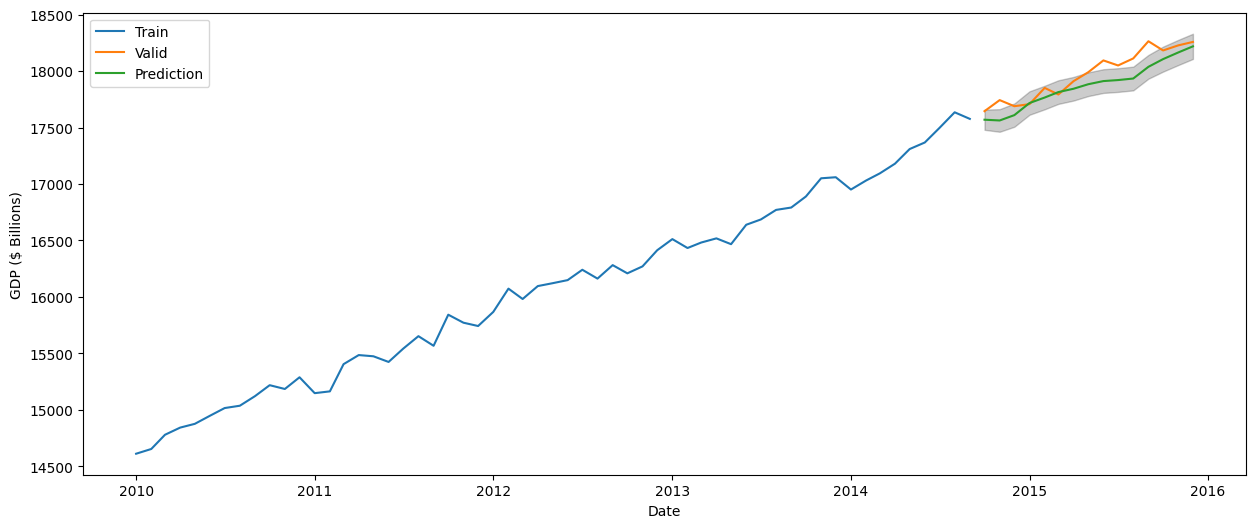

In [21]:
best_noregressors.fit(train.iloc[:,0])
best_noregressors_forecast = best_noregressors.predict(n_periods=len(valid), exogenous=True, return_conf_int=True,  alpha=0.2)

preds_best_noregressors = pd.merge(pd.DataFrame(best_noregressors_forecast[0],
                 index = pd.to_datetime(valid.index),
                 columns=['Prediction']),pd.DataFrame(best_noregressors_forecast[1][:,0],
                        index = pd.to_datetime(valid.index),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds_best_noregressors = pd.merge(preds_best_noregressors,pd.DataFrame(best_noregressors_forecast[1][:,1],
                        index = pd.to_datetime(valid.index),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

#plot the predictions for validation set
plt.plot(train.iloc[:,0], label='Train')
plt.plot(valid.iloc[:,0], label='Valid')
plt.plot(preds_best_noregressors.Prediction, label='Prediction')

plt.fill_between(preds_best_noregressors.index,preds_best_noregressors.Lower,preds_best_noregressors.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend(loc='best')
plt.show()

# ARIMA Modeling with Regressors (Target and Additional Features)
- exogenous parameter is the ony change

In [22]:
best_regressors = pm.auto_arima(train.iloc[:,0], 
                   trace=True, error_action='ignore', suppress_warnings=True,
                   seasonal=True,
                   m=12, #12 Months
                   stepwise=False,
                   D=None, 
                   max_D=10,
                   start_p=0, start_q=0, 
                   start_P=0, start_Q=0,
                   max_p=5, max_q=5, max_P=5, max_Q=5,
                   information_criterion='aic', #‘aic’, ‘bic’, ‘hqic’, ‘oob’
                   n_jobs = -1,
                   exogenous=train.iloc[:,1:]
                  )

print(best_regressors)
print('Order :',best_regressors.order)
print('Seasonal Order :',best_regressors.seasonal_order)
print('Intercept :',best_regressors.with_intercept)
print(best_regressors.summary())


Best model:  ARIMA(1,1,1)(0,0,1)[12] intercept
Total fit time: 6.618 seconds
 ARIMA(1,1,1)(0,0,1)[12] intercept
Order : (1, 1, 1)
Seasonal Order : (0, 0, 1, 12)
Intercept : True
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -319.932
Date:                            Wed, 17 Apr 2024   AIC                            649.864
Time:                                    16:13:39   BIC                            659.991
Sample:                                01-01-2010   HQIC                           653.791
                                     - 09-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

# Fit Model and Make Predictions on Validation

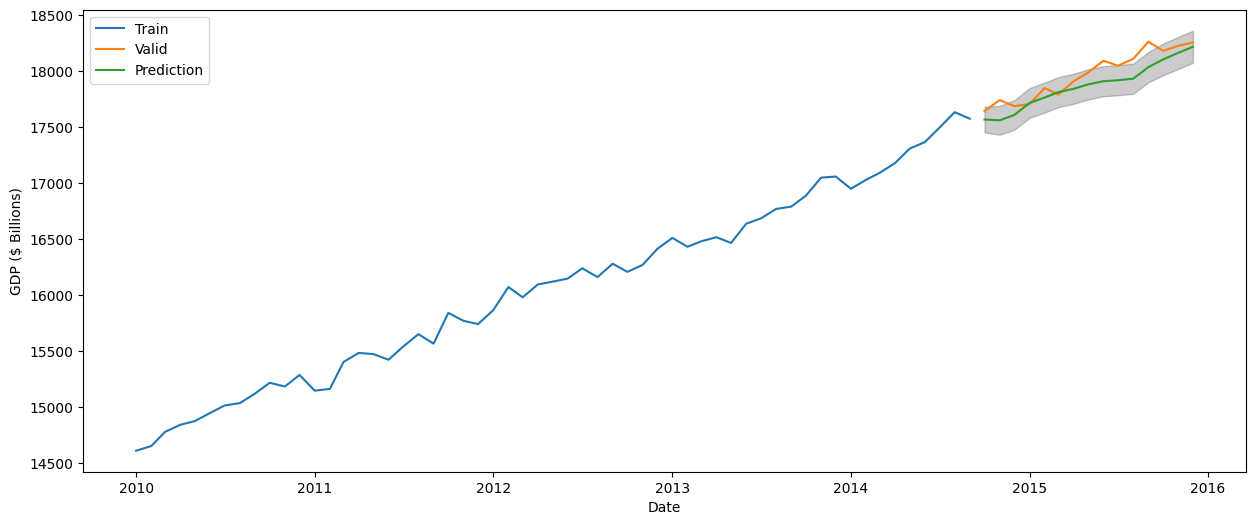

In [23]:
best_regressors.fit(train.iloc[:,0])
best_regressors_forecast = best_regressors.predict(n_periods=len(valid), exogenous=True, return_conf_int=True,  alpha=0.1)

preds_best_regressors = pd.merge(pd.DataFrame(best_regressors_forecast[0],
                 index = pd.to_datetime(valid.index),
                 columns=['Prediction']),pd.DataFrame(best_regressors_forecast[1][:,0],
                        index = pd.to_datetime(valid.index),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds_best_regressors = pd.merge(preds_best_regressors,pd.DataFrame(best_regressors_forecast[1][:,1],
                        index = pd.to_datetime(valid.index),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

#plot the predictions for validation set
plt.plot(train.iloc[:,0], label='Train')
plt.plot(valid.iloc[:,0], label='Valid')
plt.plot(preds_best_regressors.Prediction, label='Prediction')

plt.fill_between(preds_best_regressors.index,preds_best_regressors.Lower,preds_best_regressors.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend(loc='best')
plt.show()

# Choose a ARIMA model and predict future

In [24]:
pred_months = 12
model = best_regressors.fit(df.iloc[:,0])



forecast = model.predict(n_periods=pred_months, exogenous=True, return_conf_int=True,  alpha=0.25)
forecast

(2016-01-01    18370.119836
 2016-02-01    18402.642986
 2016-03-01    18496.384886
 2016-04-01    18523.031981
 2016-05-01    18562.063703
 2016-06-01    18591.512977
 2016-07-01    18666.777021
 2016-08-01    18705.408449
 2016-09-01    18736.855995
 2016-10-01    18831.163381
 2016-11-01    18876.298473
 2016-12-01    18948.579018
 Freq: MS, dtype: float64,
 array([[18288.15704549, 18452.08262675],
        [18310.30165067, 18494.98432046],
        [18399.92186483, 18592.84790663],
        [18423.98804823, 18622.07591446],
        [18460.93137044, 18663.19603589],
        [18488.48024457, 18694.54570907],
        [18561.9301391 , 18771.62390368],
        [18598.79701572, 18812.01988282],
        [18628.51556428, 18845.19642664],
        [18721.12360352, 18941.2031583 ],
        [18764.58610463, 18988.0108419 ],
        [18835.21906302, 19061.93897388]]))

In [25]:
preds = pd.merge(pd.DataFrame(forecast[0],columns=['Prediction']).reset_index(),
                 pd.DataFrame(forecast[1][:,0],columns=['Lower']),
                              how='left', left_index=True,right_index=True)
preds = pd.merge(preds,pd.DataFrame(forecast[1][:,1],columns=['Upper']),
                              how='left', left_index=True,right_index=True)

preds = preds.rename(columns={'index':'Date'})

preds = preds.set_index('Date')

display(preds)

,Prediction,Lower,Upper
Date,,,
2016-01-01,18370.119836,18288.157045,18452.082627
2016-02-01,18402.642986,18310.301651,18494.984320
2016-03-01,18496.384886,18399.921865,18592.847907
2016-04-01,18523.031981,18423.988048,18622.075914
2016-05-01,18562.063703,18460.931370,18663.196036
2016-06-01,18591.512977,18488.480245,18694.545709
2016-07-01,18666.777021,18561.930139,18771.623904
2016-08-01,18705.408449,18598.797016,18812.019883
2016-09-01,18736.855995,18628.515564,18845.196427


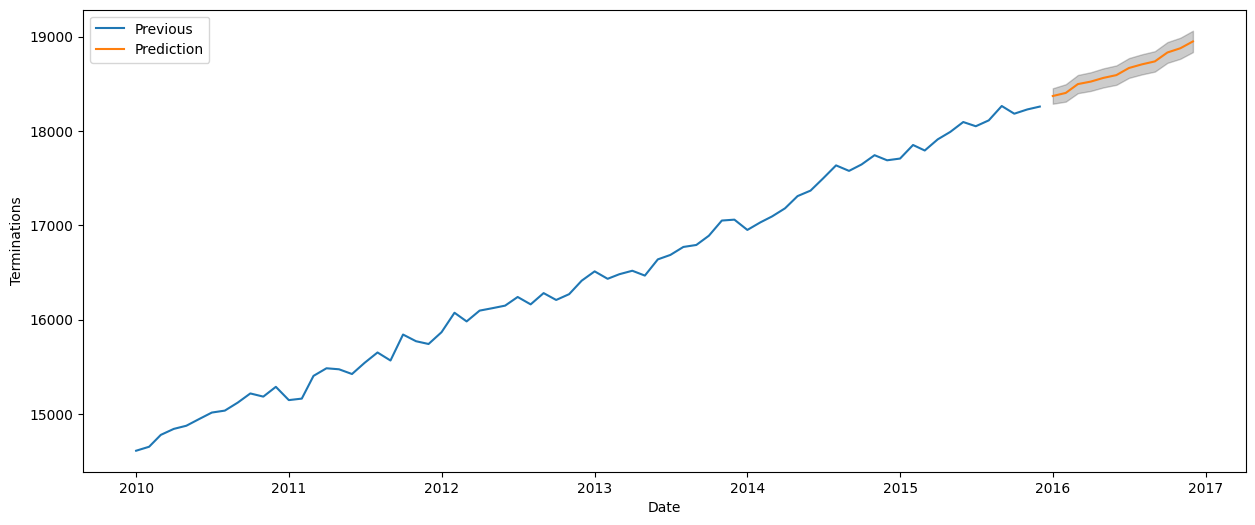

In [26]:
#plot the predictions for validation set
plt.plot(df.iloc[:,0], label='Previous')
plt.plot(preds.Prediction, label='Prediction')

plt.fill_between(preds.index,preds.Lower,preds.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel('Terminations')
plt.legend(loc='best')
plt.show()